# Saving and Loading

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from os import environ
GOOGLE_COLAB = True if "COLAB_GPU" in environ else False
if GOOGLE_COLAB:
    !pip install git+https://github.com/undark-lab/swyft.git

In [3]:
import numpy as np
import pylab as plt
import torch

import swyft

In [4]:
device = "cpu"
n_training_samples = 3000
n_parameters = 2
marginal_indices_1d, marginal_indices_2d = swyft.utils.get_corner_marginal_indices(n_parameters)
observation_key = "y"

n_posterior_samples_for_truncation = 10_000
n_rejection_samples = 10_000

In [5]:
def model(v):
    a, b = v
    x = np.linspace(-1, 1, 100)
    y = a*x + b
    return {observation_key: y}

v_o = np.zeros(n_parameters)
observation_o = model(v_o)

n_observation_features = observation_o[observation_key].shape[0]
observation_shapes = {key: value.shape for key, value in observation_o.items()}

In [9]:
simulator = swyft.Simulator(
    model, 
    n_parameters, 
    sim_shapes=observation_shapes
)

low = -1 * np.ones(n_parameters)
high = 1 * np.ones(n_parameters)
prior = swyft.get_uniform_prior(low, high)

store = swyft.Store.memory_store(simulator)
store.add(n_training_samples, prior)
store.simulate()

def noise(obs, v, sigma=0.05):
    y = obs[observation_key]
    n = np.random.randn(*y.shape)*sigma
    return {observation_key: y+n}

Creating new store.
Store: Adding 3086 new samples to simulator store.


In [10]:
dataset = swyft.Dataset(
    n_training_samples, 
    prior, 
    store, 
    simhook=noise
)

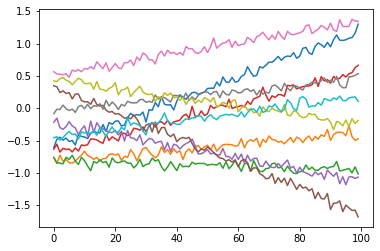

In [11]:
for i in range(10):
    plt.plot(dataset[i][0][observation_key])

In [12]:
network_1d = swyft.get_marginal_classifier(
    observation_key=observation_key,
    marginal_indices=marginal_indices_1d,
    observation_shapes=observation_shapes,
    n_parameters=n_parameters,
    hidden_features=32,
    num_blocks=2,
)
mre_1d = swyft.MarginalRatioEstimator(
    marginal_indices=marginal_indices_1d,
    network=network_1d,
    device=device,
)

In [13]:
mre_1d.train(dataset)

training: lr=0.0005, epoch=25, validation loss=1.1725


In [14]:
posterior_1d = swyft.MarginalPosterior(mre_1d, prior)
samples_1d = posterior_1d.sample(n_rejection_samples, observation_o)

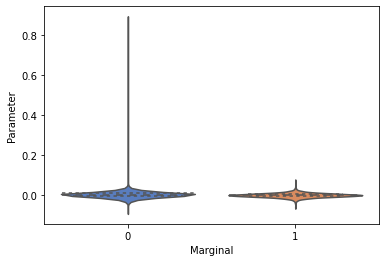

In [15]:
_ = swyft.violin(samples_1d)

# The rest is TODO

## Saving

In [ ]:
break

In [ ]:
prior.save("example3.prior.pt")
dataset.save("examples3.dataset.pt")
mre_1d.save("examples3.post.pt")

post = swyft.MarginalRatioEstimator.load("examples3.post.pt").to(DEVICE)
dataset = swyft.Dataset.load("examples3.dataset.pt", store, simhook = noise)
prior = swyft.Prior.load("example3.prior.pt")

In [ ]:
post.save("examples3.post.pt")
post = swyft.Posteriors.load("examples3.post.pt").to(DEVICE)

In [ ]:
i = 0
obs0 = dataset[i][0]
v0 = dataset[i][2]
samples=post.sample(100000, obs0)
swyft.plot_1d(samples, [0, 1], truth = v0, figsize = (12, 4), bins = 100);